In [2]:
import os
import time
import math
import random

import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

import warnings
warnings.filterwarnings('ignore')

import os
from glob import glob

import cv2
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [3]:
data_dir = '/opt/ml/input/data/train'
train_df = pd.read_csv('/opt/ml/input/data/train/train.csv')
train_df.head()

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


In [9]:
file_path = "/opt/ml/input/data/train/images"
image1 = os.path.join(file_path, train_df['path'][0], "mask1.jpg")
image2 = os.path.join(file_path, train_df['path'][1], "mask1.jpg")
image3 = os.path.join(file_path, train_df['path'][2], "mask1.jpg")

In [10]:
img1 = cv2.imread(image1)
img2 = cv2.imread(image2)
img3 = cv2.imread(image3)

In [6]:
width = img1.shape[1]
height = img1.shape[0]
img2 = cv2.resize(img2, (width, height))

dst = cv2.addWeighted(img1, 0.5, img2, 0.5, 0)

In [12]:
width = img1.shape[1]
height = img1.shape[0]
img2 = cv2.resize(img2, (width, height))

dst = cv2.addWeighted(dst, 0.5, img3, 0.5, 0)

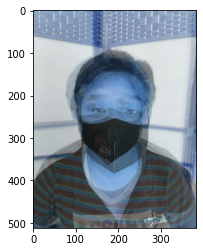

In [13]:
import matplotlib.pyplot as plt

plt.imshow(dst)

In [70]:
# mask 겹치기

total_img = np.zeros_like(img1).astype('uint32')
total_len = 0

for image_path in train_df['path']:
    try:
        mask_image_path = os.path.join(file_path, image_path, "mask1.jpg")
        mask_image = cv2.imread(mask_image_path)
        mask_image = cv2.cvtColor(mask_image, cv2.COLOR_BGR2RGB)
        total_img += mask_image.astype('uint32')
        total_len += 1
    except:
        pass

In [74]:
total_img = total_img / total_len
total_img = total_img.astype('uint8')

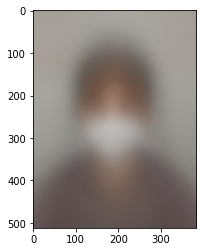

In [78]:
plt.imshow(total_img)

## 파일 경로 동일한 지 확인

In [80]:
file_names = set()

for image_path in train_df['path']:
    mask_image_path = os.path.join(file_path, image_path)
    file_names.update(os.listdir(mask_image_path))

In [81]:
file_names

{'._incorrect_mask.jpeg',
 '._incorrect_mask.jpg',
 '._incorrect_mask.png',
 '._mask1.jpeg',
 '._mask1.jpg',
 '._mask1.png',
 '._mask2.jpeg',
 '._mask2.jpg',
 '._mask2.png',
 '._mask3.jpeg',
 '._mask3.jpg',
 '._mask3.png',
 '._mask4.jpeg',
 '._mask4.jpg',
 '._mask4.png',
 '._mask5.jpeg',
 '._mask5.jpg',
 '._mask5.png',
 '._normal.jpeg',
 '._normal.jpg',
 '._normal.png',
 'incorrect_mask.jpeg',
 'incorrect_mask.jpg',
 'incorrect_mask.png',
 'mask1.jpeg',
 'mask1.jpg',
 'mask1.png',
 'mask2.jpeg',
 'mask2.jpg',
 'mask2.png',
 'mask3.jpeg',
 'mask3.jpg',
 'mask3.png',
 'mask4.jpeg',
 'mask4.jpg',
 'mask4.png',
 'mask5.jpeg',
 'mask5.jpg',
 'mask5.png',
 'normal.jpeg',
 'normal.jpg',
 'normal.png'}

## 모든 이미지 겹치기

In [ ]:
# 이름은 동일

In [86]:
total_images = dict()
mask_names = ['mask1', 'mask2', 'mask3', 'mask4', 'mask5', 'normal', 'incorrect_mask']

for mask_name in mask_names:
    mask_images = glob(file_path + f"/*/{mask_name}*")
    total_img = np.zeros_like(cv2.imread(mask_images[0])).astype('uint32')
    total_len = 0
    
    for mask_image_path in mask_images:
        try:
            mask_image = cv2.imread(mask_image_path)
            mask_image = cv2.cvtColor(mask_image, cv2.COLOR_BGR2RGB)
            total_img += mask_image.astype('uint32')
            total_len += 1
        except:
            print("something wrong")
            pass
    total_images[mask_name] = (total_img / total_len).astype('uint8')

### Mask1

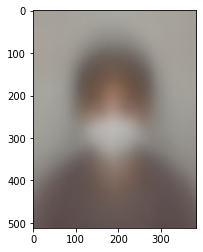

In [87]:
plt.imshow(total_images['mask1'])

### Mask2

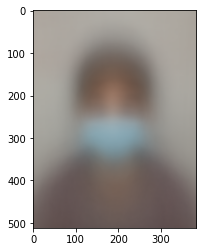

In [88]:
plt.imshow(total_images['mask2'])

### Mask3

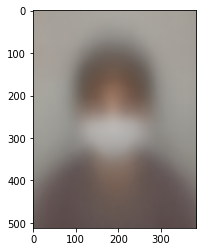

In [89]:
plt.imshow(total_images['mask3'])

### Mask4

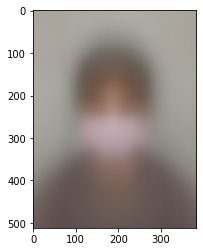

In [90]:
plt.imshow(total_images['mask4'])

### Mask5

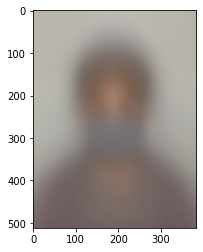

In [91]:
plt.imshow(total_images['mask5'])

### Normal

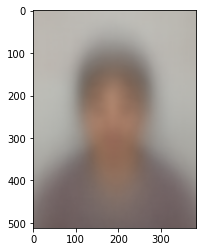

In [92]:
plt.imshow(total_images['normal'])

### InCorrect

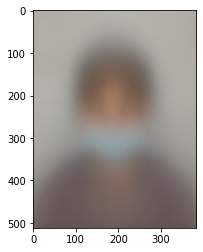

In [93]:
plt.imshow(total_images['incorrect_mask'])

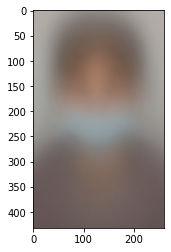

In [103]:
plt.imshow(total_images['incorrect_mask'][80:,60:320])

In [125]:
mask_image_path

'/opt/ml/input/data/train/images/000278_female_Asian_54/incorrect_mask.jpg'

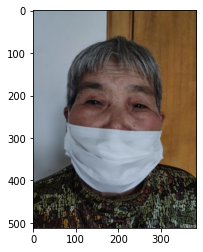

In [104]:
mask_image = cv2.imread(mask_image_path)
mask_image = cv2.cvtColor(mask_image, cv2.COLOR_BGR2RGB)
plt.imshow(mask_image)

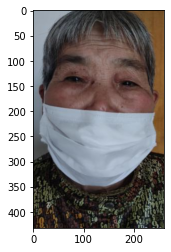

In [107]:
plt.imshow(mask_image[80:,60:320])

## 이미지 Depth 뽑아내기

> 난관에 부딪힘

In [114]:
os.chdir('/opt/ml/Mask_RCNN/')

In [116]:
ls

LICENSE      README.md  images/  mysample/         samples/   setup.py
MANIFEST.in  assets/    mrcnn/   requirements.txt  setup.cfg


In [110]:
rcnn_coco_path = '/opt/ml/another_weights/mask_rcnn_coco.h5'